# Use Streams Designer to classify newsgroup topics using an LDA model
Part 2 of 2
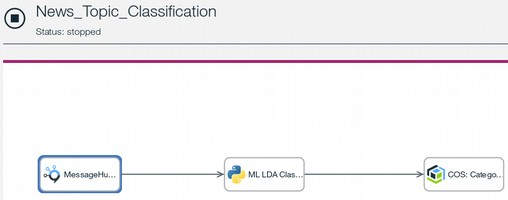
## Introduction
This is part 2 of this tutorial notebook series.  
<font color=red>**UPDATE LINK!!!**</font>  
In [part 1](https://dataplatform.ibm.com/analytics/notebooks/v2/24ca198f-bf20-4d51-b027-38017c2b94dc/view?access_token=e06a09d39b959bac9dc22782a25ba173681e8d175168bfbfc7f88065ca673a55), we created an LDA model (together with other objects) and saved it on __IBM Cloud Object Storage__.

In this tutorial notebook:
* you will be taught how to import a sample __Streams Flow__ into __IBM Cloud Streams Designer__. The _flow_ will use the LDA model to perform real-time topic classification on news items arriving from __IBM Cloud Message Hub__ and store the results on __Cloud Object Storage__.  
* Once the _Streams Flow_ is up and running, we will continue in this notebook to stream the news items to __IBM Cloud Message Hub__ so that they can be picked up by the flow.

Some familiarity with Python is recommended. This notebook has been verified for Python 3.5 and Spark 2.1.

## <a id="TOC"></a> Table of contents
1. [Use IBM Cloud Streams Designer](#flow)<br>
   1.1. [Setup](#flow1)<br>
     A. [Required IBM Cloud Services](#flow1A)<br>
     B. [[Optional] Copy a sample LDA model package to Cloud Object Storage (COS)](#flow1B)<br>
     C. [Download the sample topic classification _Streams Flow_](#flow1C)<br>
<br>
   1.2. [Create a _Streams Flow_ using _Streams Designer_](#flow2)<br>
<br>
   1.3. [Modify the flow to use your service credentials and details](#flow3)<br>
<br>
2. [Stream the news texts to Message Hub](#send)<br>
   2.1. [Setup](#send1)<br>
     A. [Install prerequisite packages](#send1A)<br>
     B. [Provide Credentials for Message Hub (MH)](#send1B)<br>
     C. [Download the sample dataset](#send1C)<br>
<br>
   2.2. [Stream the text](#send2)<br>
<br>
3. [Summary and next steps](#summary)<br>

<a id="flow"></a>
## 1. [Use IBM Cloud Streams Designer](#TOC)

<a id="flow1"></a>
### 1.1. [Setup](#TOC)

<a id="flow1A"></a>
### 1.1.A. [Required IBM Cloud Services](#TOC)
If you already have these services provisioned, just note the indicated values.

From the __IBM Cloud Dashboard__, you should provision a __Message Hub__ service.
* Create a topic to use for the flow, for example, <font color=blue>**_newsData_**</font>. This same MH topic is used in the [_Streams Flow_](#flow3) and in the next [section](#send1B) to send texts to the flow.

---

When you created your __Data Science Experience (DSX)__ project, you were asked to associate it with a __Cloud Object Storage__ service.
* Create a bucket to store the LDA model package (you should have done this in the notebook of part 1), for example, <font color=blue>**_pyml_**</font>.
* Create a bucket to store the output of the topic classification, for example, <font color=blue>**_pyml-output_**</font>.

If this is your first time using **Streams Designer**, you will be directed to associate it with a new or existing __Streaming Analytics__ service.

<a id="flow1C"></a>
### 1.1.B. [[Optional] Copy a sample LDA model package to Cloud Object Storage (COS)](#TOC)
If you did **NOT** create your own LDA model in [part 1](https://dataplatform.ibm.com/analytics/notebooks/v2/24ca198f-bf20-4d51-b027-38017c2b94dc/view?access_token=e06a09d39b959bac9dc22782a25ba173681e8d175168bfbfc7f88065ca673a55) of this tutorial series, you can download this sample model package __[news.lda_model.pkg.gz](https://raw.githubusercontent.com/raanonr/DSX/master/pyML/news.lda_model.pkg.gz)__ and upload it to a bucket (e.g., <font color=blue>**_pyml_**</font>) in your __Cloud Object Storage__ service.  
The file contains the LDA model, bigram phraser, mean topic dictionary and newsgroup category dictionary.

<a id="flow1D"></a>
### 1.1.C. [Download the sample topic classification _Streams Flow_](#TOC)
<font color=red>**UPDATE LINK!!!**</font>  
Download this sample Streams Flow __[News_Topic_Classification.stp](https://raw.githubusercontent.com/raanonr/DSX/master/pyML/News_Topic_Classification.stp)__ to local storage. It will be used in the next step.

<a id="flow2"></a>
## 1.2. [Create a Streams Flow using Streams Designer](#TOC)
Load the sample _Streams Flow_ into your _Data Science Experience_ project.
<font color=red>**UPDATE LINK!!!**</font>  
* Go to your DSX project.  
* Choose the `Assets` tab and select &oplus;__New streams flow__, located on the right of *Streams flows*.  
* Select the `From file` tab.  
* In the bottom portion of the page, browse to (or drop) the __[News_Topic_Classification.stp](https://raw.githubusercontent.com/raanonr/DSX/master/pyML/News_Topic_Classification.stp)__ _Streams Flow_ which you previously downloaded.  
* Make sure that your __Streaming Analytics service__ is selected.
* select __Create__.   

This will open the flow pictured here: 
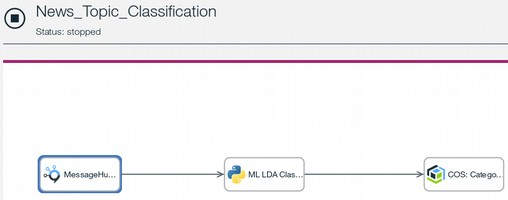

You will notice the red mark on the Notifications (bell) icon on the right, since you have to adapt the flow for your credentials and other service details.  

Select the **_Edit the streams flow_** (pencil) icon on the top right.

<a id="flow3"></a>
## 1.3. [Modify the flow to use your service credentials and details](#TOC)

You will need to modify the flow to use your service credentials and details.  
Click on the Notifications icon on the top right, then click on each error to resolve it.
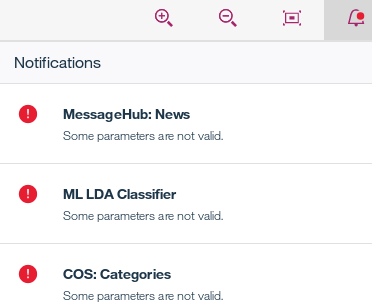

You may need to create new _connections_ to your services, with &oplus;__Add Connection__.

* Message Hub operator: Select your Message Hub service (or create a new connection to one) and choose the same topic which you created in [Required IBM Cloud Services](#flow1A), (ie, <font color=blue>**_newsData_**</font>).

* Python Machine Learning operator: Point the File Reference Name **model** to your LDA model file:
    - Select your COS service (or create a new connection to one)
    - In the **File path** field, use the **Select data asset** button on the right to select the LDA model package. In our example it's <font color=blue>__*pyml/LDA_news.model.pkg.gz*__</font>.
<table<tr><td>
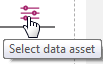
    </td><td><td><font size=150%>&#8680;</font></td><td>
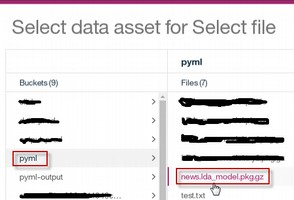
</td></tr></table>
    - You can scroll down to take a look at the Python code.
        * When initialized, it will load the NLTK lemmatizer and Part-of-Speech tagger.
        * When a **model_package** file is detected, *load_model_package()* will be called automatically, which will uncompressed and deserialize the file, then load the _state_ dictionary variable with its contents.
        * Upon the arrival of each news text document (event/tuple) from MH, it performs the following:
          - Pre-process and cleanse the text, then tokenize, lemmatize and apply the model's Bigram Phraser.
          - Use the LDA model to apply the _Bag-of-Words_ method, which assigns word frequencies to each token in the text.
          - Use the LDA model and BOWs (frequencies) to determine the match probability for each topic (saved in a list).
          - Using a similary matrix method by computing the distance between the text's topic probability list with the loaded topic list for each newsgroup, to determine the best fitting category for the text.
          - return the category and the original text.

* Cloud Object Storage operator: 
    - Select your COS service
    - In the **File path** field, enter the file pattern to use for the output files. You can use the **Select data asset** button to choose an existing bucket for the output (ie, <font color=blue>**_pyml-output_**</font>), but this will erase the sample file name provided. You can simply paste it back: <font color=blue>__*news_categories.%TIME.csv*__</font>. This file pattern means that whenever a new file is written in the bucket, it will be appended with the current date-time.
    - Take note of the **FILE CREATION** section, which will write a file every 30 seconds. (Feel free to change.)

When all of the "errors" have been resolved, **_save_** your flow, and hit **_Run_**.
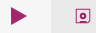

<a id="send"></a>
## 2. [Stream the news texts to Message Hub](#TOC) 
<br>   
<font color=red>Wait for your _Streams Flow_ to be in the _**running**_ state before proceeding...</font>

<a id="send1"></a>
### 2.1. [Setup](#TOC)

<a id="send1A"></a>
### 2.1.A. [Install prerequisite packages](#TOC)
Make sure that these packages are installed. (This only needs to be run once.)

In [ ]:
!pip install --user --upgrade kafka-python

If you ran the `pip install` commands above <font color=red>**RESTART**</font> the notebook kernel. From the notebook menu above, select _Kernel -> Restart and Clear Output_.

<a id="send1B"></a>
### 2.1.B. [Provide Credentials for Message Hub (MH)](#TOC)
Return to the __IBM Cloud Dashboard__ to retrieve information about your __Message Hub__ service.
* On the `Service credentials` page, select one of your credentials and copy it after hitting `View credentials`.
  * You can replace the entire content of the **mh_credentials** variable below with your credentials.  
  * Make sure that the <font color=red>_name_</font> of the credentials variable is set to **mh_credentials**.

In [1]:
# @hidden_cell
mh_credentials = {
    #<REPLACE>
}

Set the **mh_topic** variable is set to the same value you used in the [_Streams Flow_](#flow3) (ie, <font color=blue>**_newsData_**</font>).

In [2]:
mh_topic = 'newsData'

<a id="send1C"></a>
### 2.1.C. [Download the sample dataset](#TOC)
Version 3.2 of gensim (December 2017) includes a mechanism for <a href="https://radimrehurek.com/gensim/downloader.html" target="_blank" rel="noopener noreferrer">downloading</a> some sample datasets.
Even if you have a previous version of gensim, you can still download the sample dataset directly from the gensim (RaRe-Technologies) github repository (based on the source code at <a href="https://github.com/RaRe-Technologies/gensim/blob/master/gensim/downloader.py" target="_blank" rel="noopener noreferrer">https://github.com/RaRe-Technologies/gensim/blob/master/gensim/downloader.py</a>.

We will use the __20-newsgroup__ dataset, which is described as: _The notorious collection of approximately 20,000 newsgroup posts, partitioned (nearly) evenly across 20 different newsgroups._

In [3]:
DOWNLOAD_BASE_URL = "https://github.com/RaRe-Technologies/gensim-data/releases/download"
dataset="20-newsgroups"

#!rm -f {dataset}.gz*
![[ ! -f {dataset}.gz ]] && wget '{DOWNLOAD_BASE_URL}/{dataset}/{dataset}.gz'
!pwd && ls -l {dataset}.gz*

/gpfs/fs01/user/sca9-7277eb31bca08b-bc196c953de3/notebook/work
-rw------- 1 sca9-7277eb31bca08b-bc196c953de3 users 14483581 Nov  9 17:44 20-newsgroups.gz


<a id="send2"></a>
## 2.2. [Stream the text](#TOC)

### [function: read_dataset](#TOC)
Load the dataset and create a List of texts. (All stored in memory, so assume a small dataset.) 
The dataset file should be in JSON format and contain a key called **data**.

Parameters:
* dataset_path: Path and filename of the dataset file.
* max_lines: If greater than 0, abort reading the file after max_lines lines.

Returns:
* data: List of the text documents.

In [4]:
def read_dataset(dataset_path, max_lines=0):
    from smart_open import smart_open
    import json

    print("opening...", dataset_path)
    
    texts = []
    with smart_open( dataset_path, 'rb') as infile:
        for i, line in enumerate(infile):
            if max_lines > 0 and i == max_lines:
                break
            jsonData = json.loads(line.decode('utf8'))
            texts.append(jsonData['data'])

    print(len(texts), "lines read")

    return texts

### [function: create_messagehub_producer](#TOC)
Return a KafkaProducer for the Message Hub service.

Parameters:
* cred: Dictionary of MH credentials.
* value_serializer: serializer for writing the MH message. The default is to format it as a JSON object.

Returns:
* producer: KafkaProducer for the Message Hub service.

In [5]:
import json

def create_messagehub_producer(cred, value_serializer=lambda v: json.dumps(v).encode('utf-8')):
    import ssl
    from kafka import KafkaProducer
    from kafka.errors import KafkaError

    # Check for required credentials (without defaults).
    username = cred.get('username', cred.get('user'))
    password = cred.get('password')
    # Variables from credentials, but with defaults
    security_protocol = cred.get('security_protocol', 'SASL_SSL')
    sasl_mechanism = cred.get('sasl_mechanism', 'PLAIN')
    kafka_brokers_sasl = cred.get('kafka_brokers_sasl', [
        "kafka01-prod02.messagehub.services.us-south.bluemix.net:9093",
        "kafka02-prod02.messagehub.services.us-south.bluemix.net:9093",
        "kafka03-prod02.messagehub.services.us-south.bluemix.net:9093",
        "kafka04-prod02.messagehub.services.us-south.bluemix.net:9093",
        "kafka05-prod02.messagehub.services.us-south.bluemix.net:9093"
    ])

    if not username or not password:
        print("ERROR: Missing username or password")
        return

    # Create a new context using system defaults, disable all but TLS1.2
    context = ssl.create_default_context()
    context.options &= ssl.OP_NO_TLSv1
    context.options &= ssl.OP_NO_TLSv1_1

    producer = KafkaProducer(bootstrap_servers = kafka_brokers_sasl,
                             sasl_plain_username = username,
                             sasl_plain_password = password,
                             security_protocol = security_protocol,
                             ssl_context = context,
                             sasl_mechanism = sasl_mechanism,
                             client_id = mh_topic,
                             value_serializer=value_serializer)

    return producer

### [Stream the text](#TOC)

#### Read the dataset file

In [6]:
data = read_dataset(dataset + ".gz")

opening... 20-newsgroups.gz
18846 lines read


#### Create the Message Hub producer

In [7]:
mh_producer = create_messagehub_producer( mh_credentials)

#### Send all of the text data to the MH topic
This sends all of the news texts to the MH topic, pausing for 1 second every 1000 entries (to slow things down).  
You can repeat this cell as many times as you like.

In [8]:
import time

print(mh_topic)
for i, entry in enumerate(data):
    rc = mh_producer.send( mh_topic, { 'text': entry } )
    if ((i+1) % 1000) == 0:
        print(i+1, end=" ")
        time.sleep(1) # Slow things down during demo

newsData
1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 

If you switch to your _Streams Flow_, you should see the texts arriving from Message Hub into your flow...

<a id="summary"></a>
## 6. [Summary and next steps](#TOC)

You have now streamed news items to your _Streams Flow_, where they are being analyzed by an LDA Machine Learning model to determine the most likely topic of the text. The topic number, topic terms and original text are being written to _Cloud Object Storage_.

### <a id="authors"></a>Authors
**Raanon Reutlinger** is a developer at IBM Cloud Developer Services, working on the __Streams Designer__ IBM Cloud service. Raanon has over 20 years experience in the IBM Software Group, working in Data Management, Big Data and Watson teams.
<hr>
Copyright &copy; IBM Corp. 2017,2018. This notebook and its source code are released under the terms of the MIT License.